# Disaster Tweets classification (Real or not?)

## Load the packages

In [95]:
%conda install -c conda-forge beautifultable

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [96]:
import pandas as pd
import numpy as np

import re
import string
import os

import matplotlib.pyplot as plt

from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk import WordNetLemmatizer

from PIL import Image

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from beautifultable import BeautifulTable

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dense, SpatialDropout1D, Flatten, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam

In [97]:
twt = pd.read_csv('data/train.csv')

In [98]:
twt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## Data cleaning

In [99]:
def pre_process(text):
    # Remove urls
    text = re.sub('http://\S+|https://\S+', '', text)
    text = re.sub('http[s]?://\S+', '', text)
    text = re.sub(r"http\S+", "", text)
    # remove html tags
    text = re.sub('&amp', 'and', text)
    text = re.sub('&lt', '<', text)
    text = re.sub('&gt', '>', text)

    # remove emails
    text = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", text)
    # remove rt
    text = re.sub(r'\brt\b', '', text).strip()
    # Remove new line characters
    text = re.sub('[\r\n]+', ' ', text)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    # remove duplicate chars   
    text = re.sub("(.)\\1{2,}", "\\1", text)
    # Remove multiple space characters
    text = re.sub('\s+',' ', text)
    # remove special characters
    text = re.sub(r'[^\w ]+', "", text)
    text = ' '.join(text.split())
    
    # Convert to lowercase
    text = text.lower()
    return text

In [100]:
twt['text'] = twt['text'].apply(pre_process)

In [101]:
twt.head()['text']

0    our deeds are the reason of this may allah for...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    130 people receive evacuation orders in califo...
4    just got sent this photo from ruby as smoke fr...
Name: text, dtype: object

# Word visualisation

In [102]:
def get_top_n_Ngram(corpus, n=None, ngram_range=(1, 1), verbose=True):
    """
    Take in entry the following parameters
    :param verbose: print or not the table of the word and their frequency
    :param corpus: The corpus
    :param n: The number of top Ngrams
    :param ngram_range: a tuple of ngram (1, 2) means one to 2 gram
    :return: word frequency
    """
    Vect = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    Bag_of_words = Vect.transform(corpus)
    Sum_words = Bag_of_words.sum(axis=0)
    Words_freq = [(word, Sum_words[0, idx]) for word, idx in Vect.vocabulary_.items()]
    Words_freq = sorted(Words_freq, key=lambda x: x[1], reverse=True)
    common_words = Words_freq[:n]
    if verbose:
        table = BeautifulTable()
        table.columns.header = ['Words', 'Freq']
        for word, freq in common_words:
            table.rows.append([word, freq])
        print(table)
        df1 = pd.DataFrame(common_words, columns=['NGram', 'Count'])
        df1 = df1.groupby('NGram').sum()['Count'].sort_values(ascending=False)

    return df1

In [103]:
def create_word_cloud(word, mask_image, stop_w, dest_file, col=True):
    """

    :param word: list of word
    :param mask_image: path to the mask
    :param stop_w: list of stopword
    :param dest_file: destination file
    :param col: collocations is true of false
    :return:
    """
    mask = np.array(Image.open(mask_image).convert("RGB"))
    mask[mask.sum(axis=2) == 0] = 255
    # PIL_image = Image.fromarray(mask.astype('uint8'), 'RGB')
    # PIL_image.show()
    if stop_w is None:
        stpwd = stop_w
    else:
        stpwd = set(stop_w)

    word_cloud = WordCloud(contour_width=5,
                           background_color="white",
                           # mode="RGBA",
                           stopwords=stpwd,
                           mask=mask,
                           collocations=col,
                           color_func=ImageColorGenerator(mask)).generate(word)

    plt.axis('off')
    plt.tight_layout(pad=0)
    # word_cloud.recolor(color_func=img_colors)
    plt.imshow(word_cloud, interpolation="bilinear")

    # Store the image
    plt.savefig(dest_file, format="png")
    plt.show()

### Real Disaster

In [104]:
twt_1 = twt[twt['target']==1]
Most_used_words_2 = get_top_n_Ngram(twt_1['text'], n=20, ngram_range=(2, 2))


+---------------------+------+
|        Words        | Freq |
+---------------------+------+
|   suicide bomber    |  59  |
+---------------------+------+
| northern california |  41  |
+---------------------+------+
|      oil spill      |  38  |
+---------------------+------+
|  burning buildings  |  36  |
+---------------------+------+
|   suicide bombing   |  34  |
+---------------------+------+
| california wildfire |  32  |
+---------------------+------+
|      70 years       |  30  |
+---------------------+------+
|  bomber detonated   |  30  |
+---------------------+------+
|   confirmed mh370   |  29  |
+---------------------+------+
|     homes razed     |  29  |
+---------------------+------+
|    latest homes     |  28  |
+---------------------+------+
|   razed northern    |  28  |
+---------------------+------+
|      16yr old       |  28  |
+---------------------+------+
|     pkk suicide     |  28  |
+---------------------+------+
|   detonated bomb    |  28  |
+-------

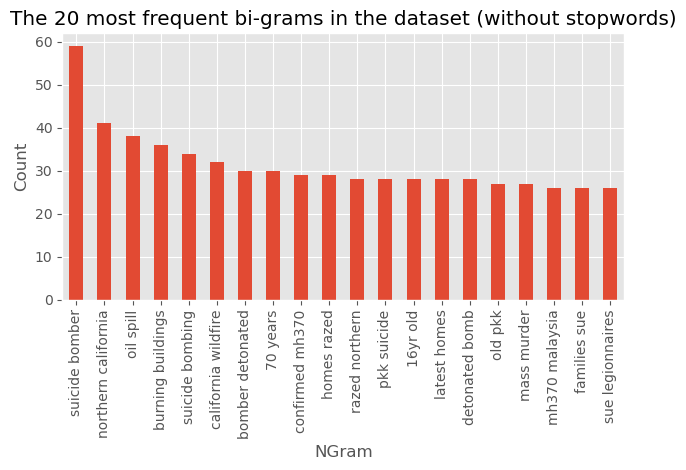

In [105]:
fig = Most_used_words_2.plot(kind='bar',
                             ylabel='Count',
                             title='The 20 most frequent bi-grams in the dataset (without stopwords)').get_figure()

plt.tight_layout()

In [106]:
Most_used_words_3 = get_top_n_Ngram(twt_1['text'], n=20, ngram_range=(3, 3))

+-------------------------------------+------+
|                Words                | Freq |
+-------------------------------------+------+
|      suicide bomber detonated       |  30  |
+-------------------------------------+------+
|    northern california wildfire     |  29  |
+-------------------------------------+------+
|         latest homes razed          |  28  |
+-------------------------------------+------+
|        homes razed northern         |  28  |
+-------------------------------------+------+
|         pkk suicide bomber          |  28  |
+-------------------------------------+------+
|        bomber detonated bomb        |  28  |
+-------------------------------------+------+
|      razed northern california      |  27  |
+-------------------------------------+------+
|            16yr old pkk             |  27  |
+-------------------------------------+------+
|           old pkk suicide           |  27  |
+-------------------------------------+------+
|      famili

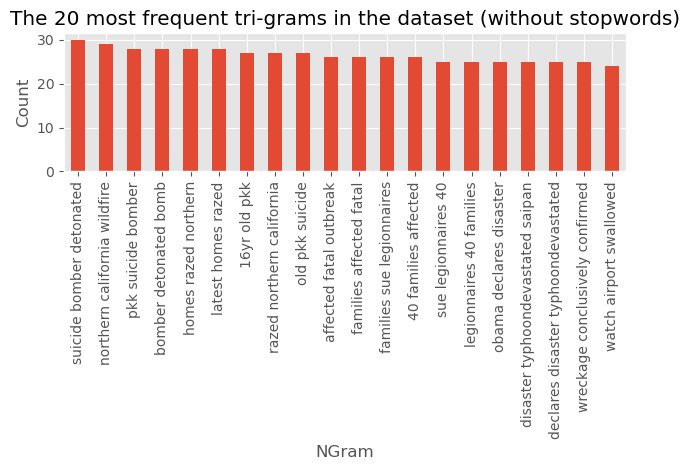

In [107]:
fig = Most_used_words_3.plot(kind='bar',
                             ylabel='Count',
                             title='The 20 most frequent tri-grams in the dataset (without stopwords)').get_figure()

plt.tight_layout()

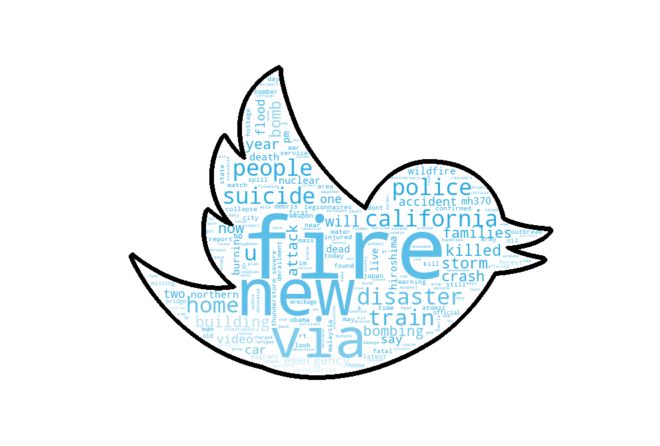

In [108]:
Wordlem = WordNetLemmatizer()

dt = twt_1['text'].apply(Wordlem.lemmatize)
words_lem = ' '.join([word for word in dt])

create_word_cloud(words_lem, "images/twitter_logo.png", STOPWORDS,
                  "images/Real_disaster_wordcloud.png", col=False)

### Fake disaster

In [109]:
twt_0 = twt[twt['target']==0]
Most_used_words_2 = get_top_n_Ngram(twt_0['text'], n=20, ngram_range=(2, 2))

+----------------------+------+
|        Words         | Freq |
+----------------------+------+
|      cross body      |  38  |
+----------------------+------+
|     liked video      |  34  |
+----------------------+------+
|       body bag       |  26  |
+----------------------+------+
|     body bagging     |  23  |
+----------------------+------+
|  burning buildings   |  23  |
+----------------------+------+
|      looks like      |  21  |
+----------------------+------+
|  reddit quarantine   |  21  |
+----------------------+------+
|      feel like       |  20  |
+----------------------+------+
|      body bags       |  20  |
+----------------------+------+
|    content policy    |  20  |
+----------------------+------+
| quarantine offensive |  18  |
+----------------------+------+
|  offensive content   |  18  |
+----------------------+------+
|      dont know       |  17  |
+----------------------+------+
|       pick fan       |  17  |
+----------------------+------+
|       

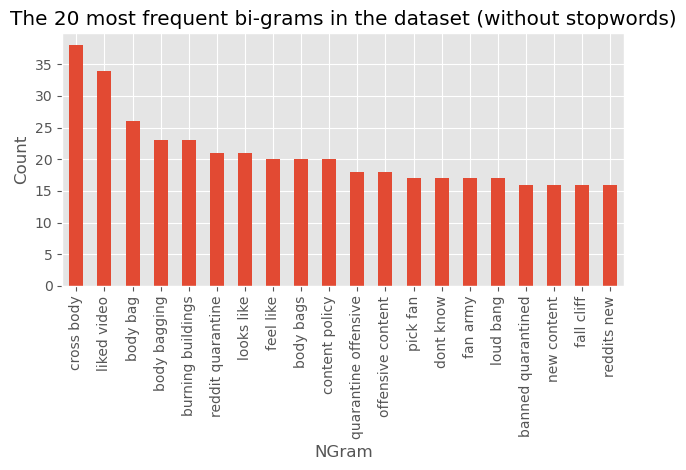

In [110]:
fig = Most_used_words_2.plot(kind='bar',
                             ylabel='Count',
                             title='The 20 most frequent bi-grams in the dataset (without stopwords)').get_figure()

plt.tight_layout()

In [111]:
Most_used_words_3 = get_top_n_Ngram(twt_0['text'], n=20, ngram_range=(3, 3))

+-------------------------------+------+
|             Words             | Freq |
+-------------------------------+------+
|        cross body bag         |  18  |
+-------------------------------+------+
|  reddit quarantine offensive  |  18  |
+-------------------------------+------+
| quarantine offensive content  |  18  |
+-------------------------------+------+
|         pick fan army         |  17  |
+-------------------------------+------+
|      reddits new content      |  16  |
+-------------------------------+------+
|      new content policy       |  16  |
+-------------------------------+------+
|      stock market crash       |  16  |
+-------------------------------+------+
|   ignition knock detonation   |  15  |
+-------------------------------+------+
|      content policy goes      |  15  |
+-------------------------------+------+
|      policy goes effect       |  15  |
+-------------------------------+------+
|     goes effect horrible      |  15  |
+---------------

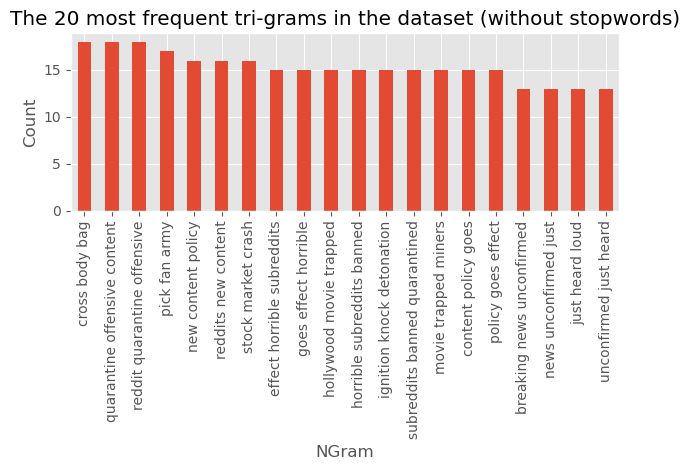

In [112]:
fig = Most_used_words_3.plot(kind='bar',
                             ylabel='Count',
                             title='The 20 most frequent tri-grams in the dataset (without stopwords)').get_figure()

plt.tight_layout()

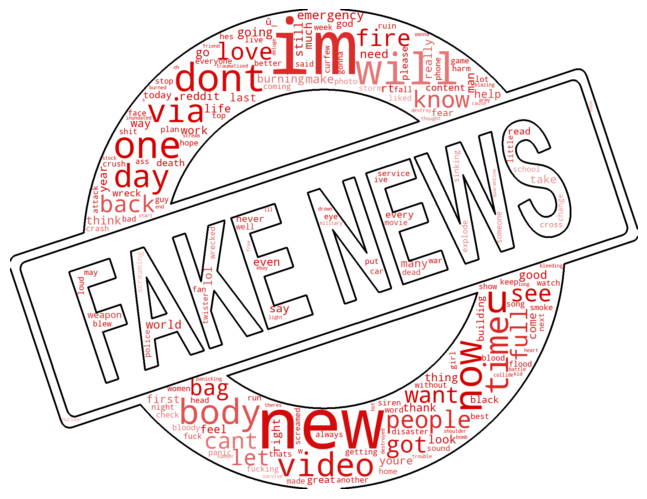

In [113]:
Wordlem = WordNetLemmatizer()

dt = twt_0['text'].apply(Wordlem.lemmatize)
words_lem = ' '.join([word for word in dt])

create_word_cloud(words_lem, "images/fake_news.png", STOPWORDS,
                  "images/fake_disaster_wordcloud.png", col=False)

## Classification with Deep Learning

In [114]:
token = Tokenizer()
token.fit_on_texts(twt['text'])

In [115]:
vocab_size = len(token.word_index) + 1

In [116]:
encoded_text = token.texts_to_sequences(twt['text'])

In [117]:
max_length = 40

X = pad_sequences(encoded_text, maxlen=max_length, padding='post')
y = twt['target']

In [118]:
X.shape, y.shape

((7613, 40), (7613,))

In [119]:
X_train, X_test,  y_train,  y_test= train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [147]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='sigmoid'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

In [148]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 40, 100)           1454000   
                                                                 
 conv1d_20 (Conv1D)          (None, 39, 32)            6432      
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 19, 32)           0         
 g1D)                                                            
                                                                 
 dropout_38 (Dropout)        (None, 19, 32)            0         
                                                                 
 dense_57 (Dense)            (None, 19, 32)            1056      
                                                                 
 dropout_39 (Dropout)        (None, 19, 32)            0         
                                                     

In [149]:
%%time
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5


2023-04-04 20:57:03.726194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - ETA: 0s - loss: 0.6839 - accuracy: 0.5703

2023-04-04 20:57:16.180439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - 14s 64ms/step - loss: 0.6839 - accuracy: 0.5703 - val_loss: 0.6836 - val_accuracy: 0.5706
Epoch 2/5
191/191 [==============================] - 7s 35ms/step - loss: 0.6799 - accuracy: 0.5727 - val_loss: 0.6552 - val_accuracy: 0.6737
Epoch 3/5
191/191 [==============================] - 5s 27ms/step - loss: 0.6014 - accuracy: 0.7072 - val_loss: 0.5602 - val_accuracy: 0.7269
Epoch 4/5
191/191 [==============================] - 5s 27ms/step - loss: 0.4586 - accuracy: 0.8320 - val_loss: 0.5282 - val_accuracy: 0.7531
Epoch 5/5
191/191 [==============================] - 5s 25ms/step - loss: 0.3540 - accuracy: 0.8782 - val_loss: 0.5590 - val_accuracy: 0.7485
CPU times: user 31.6 s, sys: 7.02 s, total: 38.6 s
Wall time: 36.3 s


### Prediction

In [69]:
def get_encoded(x):
    x =pre_process(x)
    x = token.texts_to_sequences([x])
    x = pad_sequences(x, maxlen=max_length, padding='post')
    return x

In [71]:
x = 'I am scared what an earthquake?'
vect = get_encoded(x)
np.argmax(model.predict(vect), axis=-1)

2023-04-04 20:35:10.627327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 582ms/step


array([0])